In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tdwg_lib.split_step_solver import BPMSplitStepSolver
from tdwg_lib.waveguide import Waveguide, add_absorbing_boundary
from tdwg_lib.helpers import smoothen1d, timestring
from tdwg_lib.beam_utils import gaussian_beam
from tdwg_lib.mode_solver import solve_modes
from tdwg_lib.pat import make_pat_func
from tdwg_lib import pnn_utils 
import tdwg_lib.ftutils_torch as ftutils

# Main

In [3]:
Nmodes = 3

# waveguide parameters
λ0 = 1.55 # free-space wavelength, all lengths are in um
k0 = 2*np.pi/λ0
neff = 1.8 # effective index of slab mode
d_wg = 5

# x-axis
Lx = 50 # width of simulation area (transverse dimension)
Nx = 2**9 # number of pixels in transverse dimensions
dx = Lx/(Nx-1) # stepsize in transverse dimension
x_axis = ftutils.ft_t_axis(Nx, dx)

# z-axis
dz = 0.2 # propagation step in z-direction
Lz = 1000 # length of device in propagation-direction
Nz = int(np.floor(Lz/dz))
z_axis = (torch.arange(Nz)+1)*dz

In [4]:
# Define the background delta n of the multimode waveguide
# Here, we create a step-index profile multimode waveguide of width d_wg whose edges are smoothened
# and add absorbing boundary conditions
background_delta_n = torch.zeros(Nx, dtype = torch.complex64)
background_delta_n[torch.where(x_axis.abs() < d_wg/2)] = 0.1
background_delta_n = smoothen1d(x_axis, background_delta_n, λ0)
background_delta_n = add_absorbing_boundary(x_axis, background_delta_n, k0)
# The waveguide class is just a convenient way of storing all parameters associated with the waveguide
# It doesn't do anything beyond that
wg = Waveguide(neff, x_axis, z_axis, background_delta_n)

Text(0.5, 1.0, 'Step-index profile')

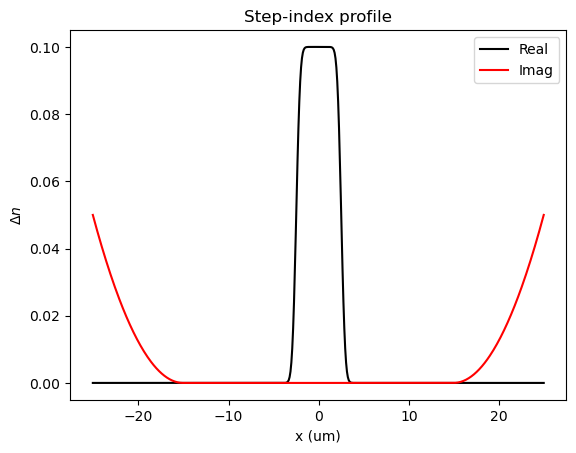

In [5]:
plt.plot(x_axis, background_delta_n.real, c='k', label = 'Real')
plt.plot(x_axis, background_delta_n.imag, c='r', label = 'Imag')
plt.xlabel('x (um)')
plt.ylabel(r'$\Delta n$')
plt.legend()
plt.title('Step-index profile')

In [6]:
# Now we find the first N TE modes and their propagation constants (betas)
betas, modes = solve_modes(wg.x_axis.numpy(), neff, k0, background_delta_n.numpy(), Nmodes, fresnel = True)
betas = torch.from_numpy(betas)
modes = torch.from_numpy(modes)

Text(0.5, 1.0, 'Waveguide modes')

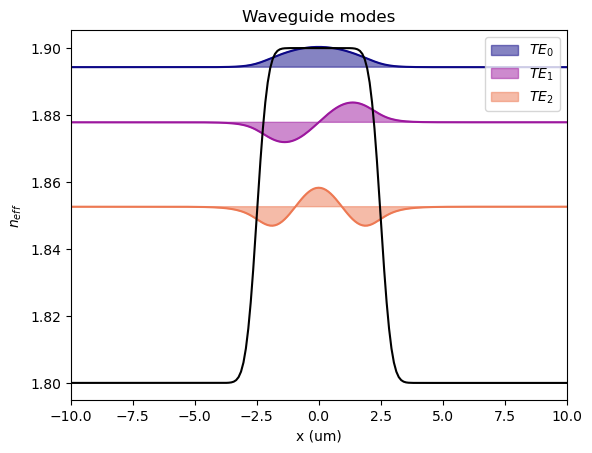

In [7]:
import matplotlib.cm as cm

for ind_mode, (mode, beta) in enumerate(zip(modes, betas)):
    plt.fill_between(x_axis, beta/k0, mode/100 + beta/k0, label = f'$TE_{ind_mode}$', color = cm.plasma(ind_mode/Nmodes), alpha = 0.5)
    plt.plot(x_axis, mode/100 + beta/k0, color = cm.plasma(ind_mode/Nmodes))
plt.plot(x_axis, neff + background_delta_n.real, c='k')

plt.legend(loc = 'upper right')
plt.xlim(-10, 10)
plt.xlabel('x (um)')
plt.ylabel(r'$n_{eff}$')
plt.title('Waveguide modes')

In [8]:
# Set up the split step solver which will integrate the PDE
bpmsolver = BPMSplitStepSolver(x_axis, z_axis, neff)

## Unperturbed propagation

In [9]:
background_delta_n_2d = wg.background_delta_n.repeat(wg.Nz,1)
E_out = bpmsolver.run_simulation(modes, background_delta_n_2d, monitor=True)

C:\Users\MartinStein\OneDrive - Yale University\Work\Github\2D-waveguide-demo-code\tdwg_lib\split_step_solver.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dz = torch.tensor(self.dz, device=device, dtype=delta_n.dtype)


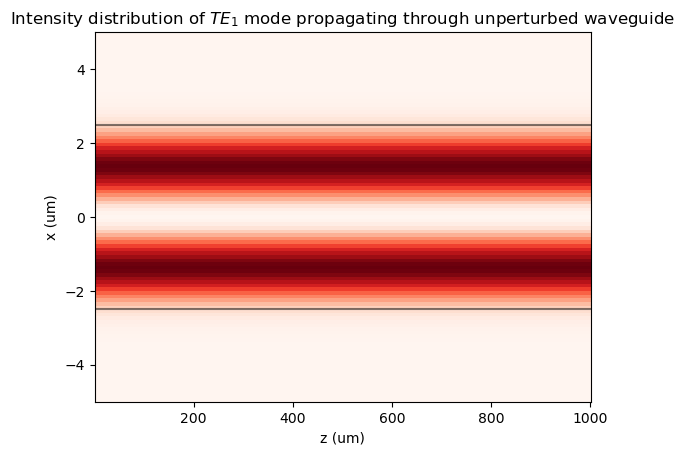

In [10]:
ind_mode = 1
plt.pcolormesh(wg.z_axis, wg.x_axis, bpmsolver.Emat_x[:,ind_mode].abs().square().T, cmap = 'Reds')
plt.xlabel('z (um)')
plt.ylabel('x (um)')
plt.title(f'Intensity distribution of $TE_{ind_mode}$ mode propagating through unperturbed waveguide')
plt.ylim(-d_wg, d_wg)
plt.axhline(d_wg/2, color = 'k', alpha = 0.5)
plt.axhline(-d_wg/2, color = 'k', alpha = 0.5)

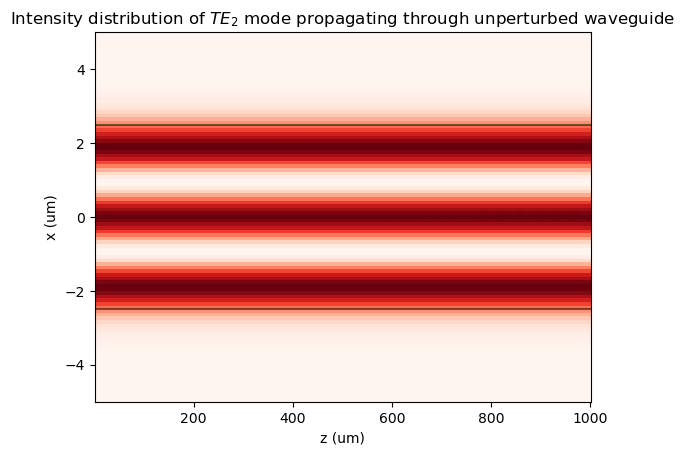

In [11]:
ind_mode = 2
plt.pcolormesh(wg.z_axis, wg.x_axis, bpmsolver.Emat_x[:,ind_mode].abs().square().T, cmap = 'Reds')
plt.xlabel('z (um)')
plt.ylabel('x (um)')
plt.title(f'Intensity distribution of $TE_{ind_mode}$ mode propagating through unperturbed waveguide')
plt.ylim(-d_wg, d_wg)
plt.axhline(d_wg/2, color = 'k', alpha = 0.5)
plt.axhline(-d_wg/2, color = 'k', alpha = 0.5)

## Coupling modes

In [12]:
# We create a refractive index grating that converts TE1 -> TE2 and vice versa
ind1, ind2 = 1, 2
dn_transverse_profile = modes[ind1] * modes[ind2] / (modes[ind1].abs().square() * modes[ind2].abs().square()*dx).sum()
dn_propagation_profile = torch.exp(1j*z_axis * (betas[ind2] - betas[ind1]))
dn = (dn_transverse_profile[None, :] * dn_propagation_profile[:, None]).real * np.pi / (k0 * Lz)

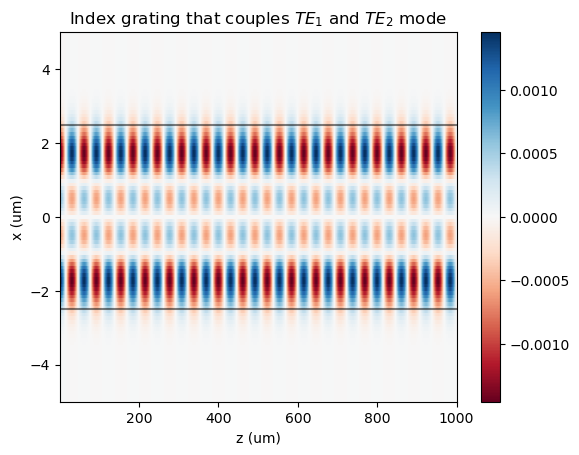

In [13]:
ind_mode = 2
plt.pcolormesh(wg.z_axis, wg.x_axis, dn.T, cmap = 'RdBu', vmin = -dn.abs().max(), vmax = dn.abs().max())
plt.xlabel('z (um)')
plt.ylabel('x (um)')
plt.title(f'Index grating that couples $TE_{ind1}$ and $TE_{ind2}$ mode')
plt.ylim(-d_wg, d_wg)
plt.axhline(d_wg/2, color = 'k', alpha = 0.5)
plt.axhline(-d_wg/2, color = 'k', alpha = 0.5)
plt.colorbar()

In [14]:
background_delta_n_2d = wg.background_delta_n.repeat(wg.Nz,1)
E_out = bpmsolver.run_simulation(modes, background_delta_n_2d + dn, monitor=True)

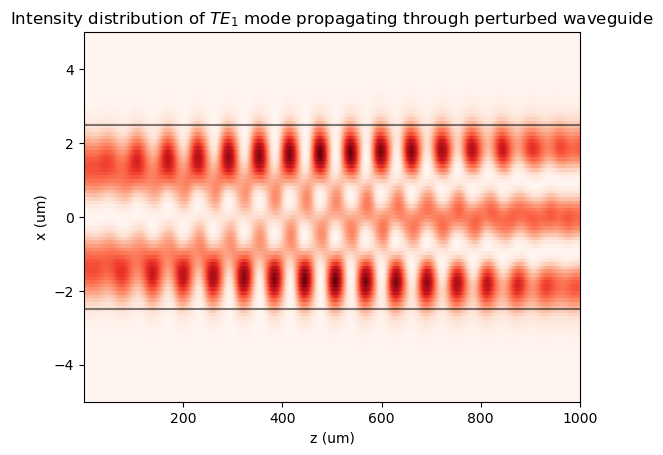

In [15]:
ind_mode = 1
plt.pcolormesh(wg.z_axis, wg.x_axis, bpmsolver.Emat_x[:,ind_mode].abs().square().T, cmap = 'Reds')
plt.xlabel('z (um)')
plt.ylabel('x (um)')
plt.title(f'Intensity distribution of $TE_{ind_mode}$ mode propagating through perturbed waveguide')
plt.ylim(-d_wg, d_wg)
plt.axhline(d_wg/2, color = 'k', alpha = 0.5)
plt.axhline(-d_wg/2, color = 'k', alpha = 0.5)

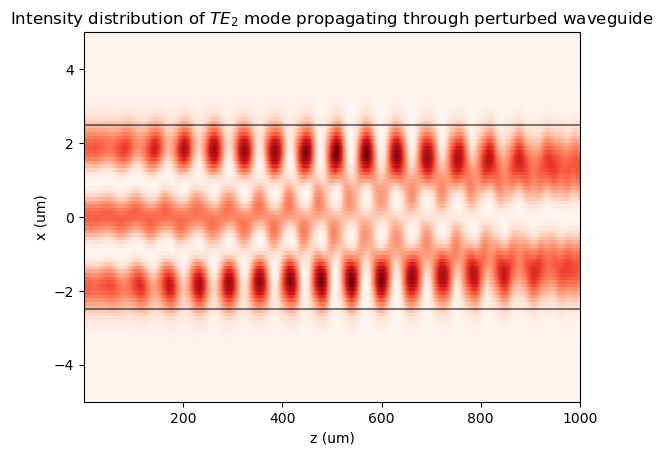

In [16]:
ind_mode = 2
plt.pcolormesh(wg.z_axis, wg.x_axis, bpmsolver.Emat_x[:,ind_mode].abs().square().T, cmap = 'Reds')
plt.xlabel('z (um)')
plt.ylabel('x (um)')
plt.title(f'Intensity distribution of $TE_{ind_mode}$ mode propagating through perturbed waveguide')
plt.ylim(-d_wg, d_wg)
plt.axhline(d_wg/2, color = 'k', alpha = 0.5)
plt.axhline(-d_wg/2, color = 'k', alpha = 0.5)